***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.4)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While changing the primary capsule dimension ($P_{capsule} = 16D$). Training without $L_{cons}$
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD_2\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "3" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  3
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_2_4')

FOLDER CREATED =  ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss_P16


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 16

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)
    
    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 2)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
780/781 [============================>.] - ETA: 0s - loss: 0.3378 - prediction_coarse_accuracy: 0.8332 - prediction_medium_accuracy: 0.3924 - prediction_fine_accuracy: 0.2086
  • Coarse Accuracy = 83.33% | Val_Accuracy = 87.06% | LossWeight = 0.16 
  • Medium Accuracy = 39.26% | Val_Accuracy = 48.55% | LossWeight = 0.42 
  • Fine   Accuracy = 20.89% | Val_Accuracy = 31.80% | LossWeight = 0.41 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.31800, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 59s 64ms/step - loss: 0.3377 - prediction_coarse_accuracy: 0.8333 - prediction_medium_accuracy: 0.3926 - prediction_fine_accuracy: 0.2089 - val_loss: 0.2558 - val_prediction_coarse_accuracy: 0.8706 - val_prediction_medium_accuracy: 0.4855 - val_prediction_fine_accuracy: 0.3180 - lr: 0.0010
Epoch 2/100
780/781 [============================>.] - ETA: 0s - loss: 0.2372 - prediction_coarse_acc

780/781 [============================>.] - ETA: 0s - loss: 0.1733 - prediction_coarse_accuracy: 0.9056 - prediction_medium_accuracy: 0.6880 - prediction_fine_accuracy: 0.5561
  • Coarse Accuracy = 90.55% | Val_Accuracy = 90.06% | LossWeight = 0.17 
  • Medium Accuracy = 68.79% | Val_Accuracy = 69.37% | LossWeight = 0.40 
  • Fine   Accuracy = 55.61% | Val_Accuracy = 55.95% | LossWeight = 0.43 

Epoch 9: val_prediction_fine_accuracy did not improve from 0.57290
781/781 [==============================] - 40s 52ms/step - loss: 0.1733 - prediction_coarse_accuracy: 0.9055 - prediction_medium_accuracy: 0.6879 - prediction_fine_accuracy: 0.5561 - val_loss: 0.1562 - val_prediction_coarse_accuracy: 0.9006 - val_prediction_medium_accuracy: 0.6937 - val_prediction_fine_accuracy: 0.5595 - lr: 0.0010
Epoch 10/100
780/781 [============================>.] - ETA: 0s - loss: 0.1747 - prediction_coarse_accuracy: 0.8943 - prediction_medium_accuracy: 0.6843 - prediction_fine_accuracy: 0.5615
  • Coarse Ac

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1051 - prediction_coarse_accuracy: 0.9562 - prediction_medium_accuracy: 0.8483 - prediction_fine_accuracy: 0.7799
  • Coarse Accuracy = 95.62% | Val_Accuracy = 96.72% | LossWeight = 0.16 
  • Medium Accuracy = 84.83% | Val_Accuracy = 84.89% | LossWeight = 0.40 
  • Fine   Accuracy = 77.99% | Val_Accuracy = 79.24% | LossWeight = 0.44 

Epoch 18: val_prediction_fine_accuracy improved from 0.77620 to 0.79240, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 41s 52ms/step - loss: 0.1051 - prediction_coarse_accuracy: 0.9562 - prediction_medium_accuracy: 0.8483 - prediction_fine_accuracy: 0.7799 - val_loss: 0.0742 - val_prediction_coarse_accuracy: 0.9672 - val_prediction_medium_accuracy: 0.8489 - val_prediction_fine_accuracy: 0.7924 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1010 - prediction_

Epoch 27/100
780/781 [============================>.] - ETA: 0s - loss: 0.0797 - prediction_coarse_accuracy: 0.9716 - prediction_medium_accuracy: 0.9106 - prediction_fine_accuracy: 0.8652
  • Coarse Accuracy = 97.16% | Val_Accuracy = 97.47% | LossWeight = 0.17 
  • Medium Accuracy = 91.06% | Val_Accuracy = 87.53% | LossWeight = 0.39 
  • Fine   Accuracy = 86.52% | Val_Accuracy = 83.24% | LossWeight = 0.44 

Epoch 27: val_prediction_fine_accuracy did not improve from 0.83700
781/781 [==============================] - 47s 60ms/step - loss: 0.0798 - prediction_coarse_accuracy: 0.9716 - prediction_medium_accuracy: 0.9106 - prediction_fine_accuracy: 0.8652 - val_loss: 0.0612 - val_prediction_coarse_accuracy: 0.9747 - val_prediction_medium_accuracy: 0.8753 - val_prediction_fine_accuracy: 0.8324 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0789 - prediction_coarse_accuracy: 0.9716 - prediction_medium_accuracy: 0.9126 - prediction_fine_accuracy: 0.

780/781 [============================>.] - ETA: 0s - loss: 0.0660 - prediction_coarse_accuracy: 0.9792 - prediction_medium_accuracy: 0.9430 - prediction_fine_accuracy: 0.9199
  • Coarse Accuracy = 97.91% | Val_Accuracy = 97.97% | LossWeight = 0.20 
  • Medium Accuracy = 94.29% | Val_Accuracy = 90.24% | LossWeight = 0.39 
  • Fine   Accuracy = 91.99% | Val_Accuracy = 86.46% | LossWeight = 0.41 

Epoch 45: val_prediction_fine_accuracy improved from 0.86300 to 0.86460, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_WO_C_loss_P16\epoch-best.h5
781/781 [==============================] - 42s 54ms/step - loss: 0.0660 - prediction_coarse_accuracy: 0.9791 - prediction_medium_accuracy: 0.9429 - prediction_fine_accuracy: 0.9199 - val_loss: 0.0511 - val_prediction_coarse_accuracy: 0.9797 - val_prediction_medium_accuracy: 0.9024 - val_prediction_fine_accuracy: 0.8646 - lr: 1.6608e-04
Epoch 46/100
780/781 [============================>.] - ETA: 0s - loss: 0.0651 - prediction_coarse_accura

781/781 [==============================] - 66s 85ms/step - loss: 0.0618 - prediction_coarse_accuracy: 0.9807 - prediction_medium_accuracy: 0.9530 - prediction_fine_accuracy: 0.9364 - val_loss: 0.0489 - val_prediction_coarse_accuracy: 0.9808 - val_prediction_medium_accuracy: 0.9049 - val_prediction_fine_accuracy: 0.8666 - lr: 6.5971e-05
Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0616 - prediction_coarse_accuracy: 0.9806 - prediction_medium_accuracy: 0.9523 - prediction_fine_accuracy: 0.9352
  • Coarse Accuracy = 98.06% | Val_Accuracy = 98.09% | LossWeight = 0.22 
  • Medium Accuracy = 95.23% | Val_Accuracy = 90.74% | LossWeight = 0.39 
  • Fine   Accuracy = 93.52% | Val_Accuracy = 86.87% | LossWeight = 0.39 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.86930
781/781 [==============================] - 66s 85ms/step - loss: 0.0616 - prediction_coarse_accuracy: 0.9806 - prediction_medium_accuracy: 0.9523 - prediction_fine_accuracy: 0.9352 - 

Epoch 73/100
781/781 [==============================] - ETA: 0s - loss: 0.0602 - prediction_coarse_accuracy: 0.9819 - prediction_medium_accuracy: 0.9550 - prediction_fine_accuracy: 0.9395
  • Coarse Accuracy = 98.19% | Val_Accuracy = 98.23% | LossWeight = 0.22 
  • Medium Accuracy = 95.50% | Val_Accuracy = 90.87% | LossWeight = 0.39 
  • Fine   Accuracy = 93.95% | Val_Accuracy = 87.01% | LossWeight = 0.39 

Epoch 73: val_prediction_fine_accuracy did not improve from 0.87140
781/781 [==============================] - 65s 84ms/step - loss: 0.0602 - prediction_coarse_accuracy: 0.9819 - prediction_medium_accuracy: 0.9550 - prediction_fine_accuracy: 0.9395 - val_loss: 0.0483 - val_prediction_coarse_accuracy: 0.9823 - val_prediction_medium_accuracy: 0.9087 - val_prediction_fine_accuracy: 0.8701 - lr: 3.9499e-05
Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0606 - prediction_coarse_accuracy: 0.9813 - prediction_medium_accuracy: 0.9538 - prediction_fine_accuracy: 0.

781/781 [==============================] - 63s 81ms/step - loss: 0.0605 - prediction_coarse_accuracy: 0.9817 - prediction_medium_accuracy: 0.9550 - prediction_fine_accuracy: 0.9413 - val_loss: 0.0477 - val_prediction_coarse_accuracy: 0.9824 - val_prediction_medium_accuracy: 0.9098 - val_prediction_fine_accuracy: 0.8715 - lr: 2.4894e-05
Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.0604 - prediction_coarse_accuracy: 0.9813 - prediction_medium_accuracy: 0.9553 - prediction_fine_accuracy: 0.9417
  • Coarse Accuracy = 98.13% | Val_Accuracy = 98.22% | LossWeight = 0.23 
  • Medium Accuracy = 95.53% | Val_Accuracy = 90.95% | LossWeight = 0.39 
  • Fine   Accuracy = 94.17% | Val_Accuracy = 87.09% | LossWeight = 0.38 

Epoch 83: val_prediction_fine_accuracy did not improve from 0.87210
781/781 [==============================] - 65s 83ms/step - loss: 0.0604 - prediction_coarse_accuracy: 0.9813 - prediction_medium_accuracy: 0.9553 - prediction_fine_accuracy: 0.9417 - 

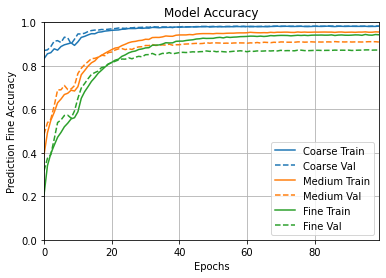

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

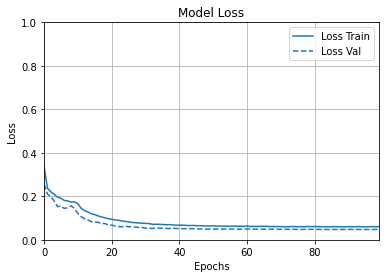

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 11s 25ms/step - loss: 0.0670 - prediction_coarse_loss: 0.0160 - prediction_medium_loss: 0.0675 - prediction_fine_loss: 0.0952 - prediction_coarse_accuracy: 0.9824 - prediction_medium_accuracy: 0.9096 - prediction_fine_accuracy: 0.8724
1. loss ==> 0.06701613962650299
2. prediction_coarse_loss ==> 0.016010738909244537
3. prediction_medium_loss ==> 0.0675143375992775
4. prediction_fine_loss ==> 0.09523824602365494
5. prediction_coarse_accuracy ==> 0.9824000000953674
6. prediction_medium_accuracy ==> 0.909600019454956
7. prediction_fine_accuracy ==> 0.8723999857902527
313/313 [==============================] - 6s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

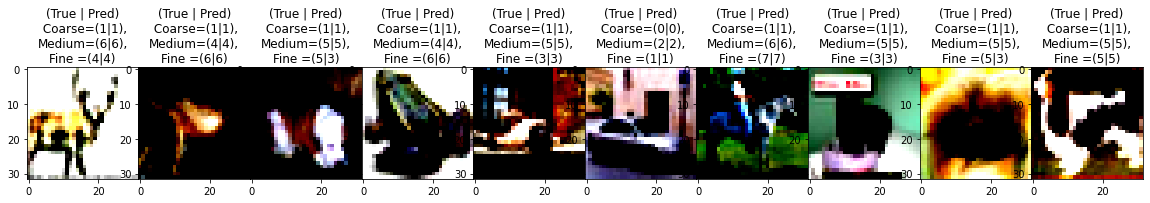

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3920   80]
 [  96 5904]]

  • MEDIUM LEVEL 
[[ 908   22   25   14    2   15   14]
 [  36  926   26    2    2    4    4]
 [  18    9 1964    2    1    4    2]
 [  32    3    8  811   36   60   50]
 [   3    2    3   18  933   36    5]
 [  14    8   21   66   57 1738   96]
 [  14    5    8   39   38   80 1816]]

  • FINE LEVEL 
[[911  10  17  11   4   3   2   8  21  13]
 [ 10 949   0   2   0   0   0   0   6  33]
 [ 32   3 815  30  33  20  38  23   3   3]
 [ 10   4  45 717  31 107  46  24   6  10]
 [  5   1  37  23 842  10  38  38   5   1]
 [  7   1  24 127  22 776  17  19   2   5]
 [  3   1  18  27   4   5 937   1   2   2]
 [ 11   2   5  20  24  21   3 910   0   4]
 [ 34   8   3   4   2   1   2   2 927  17]
 [ 10  37   2   5   0   0   2   0   4 940]]

  • Classification Report 


  • COARSE LEVEL 


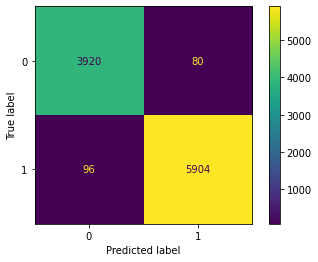

              precision    recall  f1-score   support

           0    0.97610   0.98000   0.97804      4000
           1    0.98663   0.98400   0.98531      6000

    accuracy                        0.98240     10000
   macro avg    0.98136   0.98200   0.98168     10000
weighted avg    0.98242   0.98240   0.98241     10000


  • MEDIUM LEVEL 


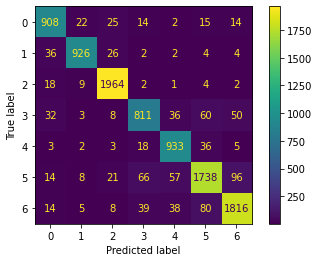

              precision    recall  f1-score   support

           0    0.88585   0.90800   0.89679      1000
           1    0.94974   0.92600   0.93772      1000
           2    0.95572   0.98200   0.96868      2000
           3    0.85189   0.81100   0.83094      1000
           4    0.87278   0.93300   0.90188      1000
           5    0.89726   0.86900   0.88291      2000
           6    0.91394   0.90800   0.91096      2000

    accuracy                        0.90960     10000
   macro avg    0.90388   0.90529   0.90427     10000
weighted avg    0.90941   0.90960   0.90924     10000


  • FINE LEVEL 


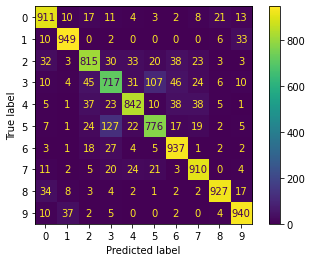

              precision    recall  f1-score   support

           0    0.88190   0.91100   0.89621      1000
           1    0.93406   0.94900   0.94147      1000
           2    0.84369   0.81500   0.82909      1000
           3    0.74224   0.71700   0.72940      1000
           4    0.87526   0.84200   0.85831      1000
           5    0.82291   0.77600   0.79876      1000
           6    0.86359   0.93700   0.89880      1000
           7    0.88780   0.91000   0.89877      1000
           8    0.94980   0.92700   0.93826      1000
           9    0.91440   0.94000   0.92702      1000

    accuracy                        0.87240     10000
   macro avg    0.87156   0.87240   0.87161     10000
weighted avg    0.87156   0.87240   0.87161     10000



In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9209183333333334 
Hierarchical Recall = 0.9235333333333334 
Hierarchical F1-Score = 0.9220011904761904 
Consistency =  0.9862 
Exact Match =  0.8675
